In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [400]:
def analyze_classifier(model, X_train, X_test, y_train, y_test, response='Response', classes=[0, 1, 2]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if len(classes) == 2:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None
    
def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']), predictions], axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={0:'No_Predicted',
                            1:'Yes_Predicted'}, 
                  index={0:'No_True',
                            1:'Yes_True'},
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),5), matrix, predicted_probs
    

### Load/Clean Data

In [340]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x:len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


In [341]:
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())
len(data[data['last_review'].isna()])

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


10052

### Convert Features to Types

In [342]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data['calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])


### Add some derived features

- Reviews per month to categorical

- Days Since Last Review (imputed to max value where null)

In [343]:
#data[data.reviews_per_month < 10]['reviews_per_month'].hist(bins=10)
#appropriate bins are 1, 2, 3, 4, 5
%matplotlib inline
data['reviews_per_month'].fillna(0, inplace=True)
data['reviews_per_month_cut'] = pd.cut(data.reviews_per_month, bins=range(0,6)
                                       , labels=['Less Than One', 'Less Than 2', 'Less Than Three', 'Less Than Four', 'Less Than Five'])
data['reviews_per_month_cut'].cat.add_categories(['Greater Than Five'], inplace=True)
data.loc[data.reviews_per_month_cut.isna(), ['reviews_per_month_cut']] = 'Greater Than Five'

In [344]:
data['days_since_last_review'] = (dt.datetime.strptime('2020-01-01', '%Y-%m-%d') - data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(), inplace=True) 
data.drop(columns=['last_review'], inplace=True)

### Drop useless cols

In [345]:
data.drop(columns=['id', 'name', 'host_id', 'host_name'], inplace=True)

In [346]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room,days_since_last_review
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520,1018.678331
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089,1169.872743
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000,196.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000,363.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000,1378.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000,3201.000000


### Define feature set

In [364]:
#features = ['neighbourhood_group'
#            , 'neighbourhood'
#            , 'latitude'
#            , 'longitude'
#            , 'price'
#            , 'minimum_nights'
#            , 'number_of_reviews'
#            , 'reviews_per_month'
#            , 'calculated_host_listings_count'
#            , 'availability_365']
data.dtypes
target = 'room_type'

### EDA / Visualizations

In [365]:
data.groupby(['neighbourhood_group', 'room_type']).mean().sort_values(['price'], ascending=False)

latitude  longitude       price  \
neighbourhood_group room_type                                           
Manhattan           Entire home/apt  40.761161 -73.976205  174.806363   
Brooklyn            Entire home/apt  40.684380 -73.954864  145.022469   
Queens              Entire home/apt  40.729015 -73.874570  129.953649   
Staten Island       Entire home/apt  40.606978 -74.108550  118.865385   
Bronx               Entire home/apt  40.847280 -73.880639  111.213650   
Manhattan           Private room     40.776605 -73.968191   97.876583   
                    Shared room      40.771042 -73.971508   74.904545   
Brooklyn            Private room     40.685431 -73.947159   70.956345   
Queens              Private room     40.732772 -73.869415   67.206863   
Staten Island       Private room     40.614541 -74.102727   61.564972   
Bronx               Private room     40.849192 -73.886045   60.256039   
Staten Island       Shared room      40.609894 -74.091077   57.444444   
Brooklyn            Shared room      40.666306 -73.951473   50.352071   
Bronx               Shared room      40.839415 -73.893532   47.637931   
Queens              Shared room      40.734629 -73.869705   46.586592   

                                     minimum_nights  number_of_reviews  \
neighbourhood_group room_type                                            
Manhattan           Entire home/apt        3.383567          22.170075   
Brooklyn            Entire home/apt        3.436275          29.963675   
Queens              Entire home/apt        2.986681          30.670218   
Staten Island       Entire home/apt        2.660256          36.839744   
Bronx               Entire home/apt        2.718101          33.459941   
Manhattan           Private room           2.887853          28.258661   
                    Shared room            2.431818          22.750000   
Brooklyn            Private room           3.042160          22.100971   
Queens              Private room           2.392484          29.928431   
Staten Island       Private room           2.186441          31.451977   
Bronx               Private room           2.331723          25.821256   
Staten Island       Shared room            2.333333           1.555556   
Brooklyn            Shared room            2.872781          16.745562   
Bronx               Shared room            1.896552           7.431034   
Queens              Shared room            1.932961          15.067039   

                                     reviews_per_month  \
neighbourhood_group room_type                            
Manhattan           Entire home/apt           1.009955   
Brooklyn            Entire home/apt           1.215671   
Queens              Entire home/apt           1.741151   
Staten Island       Entire home/apt           1.946474   
Bronx               Entire home/apt           1.995668   
Manhattan           Private room              1.225212   
                    Shared room               1.431864   
Brooklyn            Private room              1.036658   
Queens              Private room              1.675729   
Staten Island       Private room              1.507853   
Bronx               Private room              1.369581   
Staten Island       Shared room               0.740000   
Brooklyn            Shared room               0.899615   
Bronx               Shared room               1.001552   
Queens              Shared room               1.282905   

                                     calculated_host_listings_count  \
neighbourhood_group room_type                                         
Manhattan           Entire home/apt                        6.555197   
Brooklyn            Entire home/apt                        1.387218   
Queens              Entire home/apt                        1.535962   
Staten Island       Entire home/apt                        1.570513   
Bronx               Entire home/apt                        1.744807   
Manhattan           Private room                     

In [366]:
data.groupby(['neighbourhood_group', 'room_type']).agg(['mean','median', 'min', 'max','count'])[['price']]

price                          
                                           mean median   min    max count
neighbourhood_group room_type                                            
Bronx               Entire home/apt  111.213650  100.0  28.0  299.0   337
                    Private room      60.256039   55.0  10.0  240.0   621
                    Shared room       47.637931   40.0  20.0  165.0    58
Brooklyn            Entire home/apt  145.022469  139.0  10.0  299.0  8011
                    Private room      70.956345   65.0  10.0  299.0  9369
                    Shared room       50.352071   38.0  15.0  250.0   338
Manhattan           Entire home/apt  174.806363  175.0  10.0  299.0  8361
                    Private room      97.876583   90.0  10.0  299.0  7187
                    Shared room       74.904545   68.0  10.0  299.0   440
Queens              Entire home/apt  129.953649  120.0  10.0  299.0  1877
                    Private room      67.206863   60.0  10.0  289.0  3060
                    Shared room       46.586592   37.0  11.0  200.0   179
Staten Island       Entire home/apt  118.865385  100.0  48.0  299.0   156
                    Private room      61.564972   52.0  20.0  235.0   177
                    Shared room       57.444444   30.0  13.0  150.0     9

#### Price Outliers 

- Drop stuff with zero price

- Drop anything with price >= 300

In [367]:
data = data.reindex(data[data.price !=0].index)
data.groupby(['neighbourhood_group', 'room_type']).agg(['mean','median', 'min', 'max','count'])[['price']]

price                          
                                           mean median   min    max count
neighbourhood_group room_type                                            
Bronx               Entire home/apt  111.213650  100.0  28.0  299.0   337
                    Private room      60.256039   55.0  10.0  240.0   621
                    Shared room       47.637931   40.0  20.0  165.0    58
Brooklyn            Entire home/apt  145.022469  139.0  10.0  299.0  8011
                    Private room      70.956345   65.0  10.0  299.0  9369
                    Shared room       50.352071   38.0  15.0  250.0   338
Manhattan           Entire home/apt  174.806363  175.0  10.0  299.0  8361
                    Private room      97.876583   90.0  10.0  299.0  7187
                    Shared room       74.904545   68.0  10.0  299.0   440
Queens              Entire home/apt  129.953649  120.0  10.0  299.0  1877
                    Private room      67.206863   60.0  10.0  289.0  3060
                    Shared room       46.586592   37.0  11.0  200.0   179
Staten Island       Entire home/apt  118.865385  100.0  48.0  299.0   156
                    Private room      61.564972   52.0  20.0  235.0   177
                    Shared room       57.444444   30.0  13.0  150.0     9

In [368]:
data = data.reindex(data[data.price < 300].index)
data.groupby(['neighbourhood_group', 'room_type']).agg(['mean','median', 'min', 'max','count'])[['price']]

price                          
                                           mean median   min    max count
neighbourhood_group room_type                                            
Bronx               Entire home/apt  111.213650  100.0  28.0  299.0   337
                    Private room      60.256039   55.0  10.0  240.0   621
                    Shared room       47.637931   40.0  20.0  165.0    58
Brooklyn            Entire home/apt  145.022469  139.0  10.0  299.0  8011
                    Private room      70.956345   65.0  10.0  299.0  9369
                    Shared room       50.352071   38.0  15.0  250.0   338
Manhattan           Entire home/apt  174.806363  175.0  10.0  299.0  8361
                    Private room      97.876583   90.0  10.0  299.0  7187
                    Shared room       74.904545   68.0  10.0  299.0   440
Queens              Entire home/apt  129.953649  120.0  10.0  299.0  1877
                    Private room      67.206863   60.0  10.0  289.0  3060
                    Shared room       46.586592   37.0  11.0  200.0   179
Staten Island       Entire home/apt  118.865385  100.0  48.0  299.0   156
                    Private room      61.564972   52.0  20.0  235.0   177
                    Shared room       57.444444   30.0  13.0  150.0     9

In [369]:
data = data[data.minimum_nights <= 20]
data.to_csv('airbnb_clean.csv', index=False)

Text(0, 0.5, 'Freq')

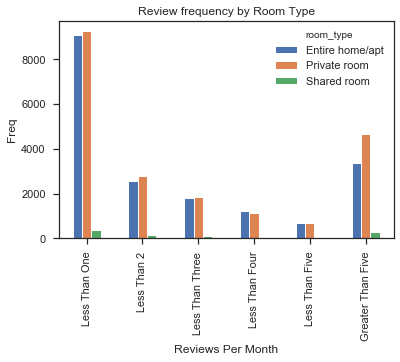

In [370]:
%matplotlib inline
pd.crosstab(data.reviews_per_month_cut, data.room_type).plot(kind='bar')
plt.title('Review frequency by Room Type')
plt.xlabel('Reviews Per Month')
plt.ylabel('Freq')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3C83A5548>,
      dtype=object)

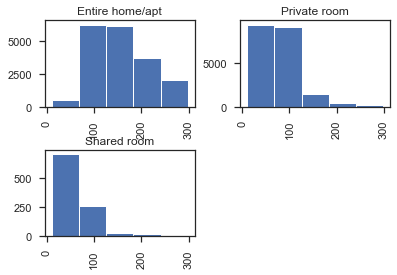

In [371]:
%matplotlib inline
data['price'].hist(by=data['room_type'], bins=5)
#plt.title('Price  by Room Type')
#plt.xlabel('Price')
#plt.ylabel('Freq')

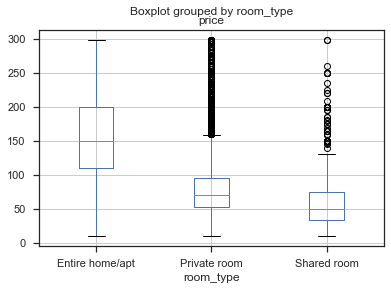

In [372]:
data.boxplot(column='price',by='room_type')

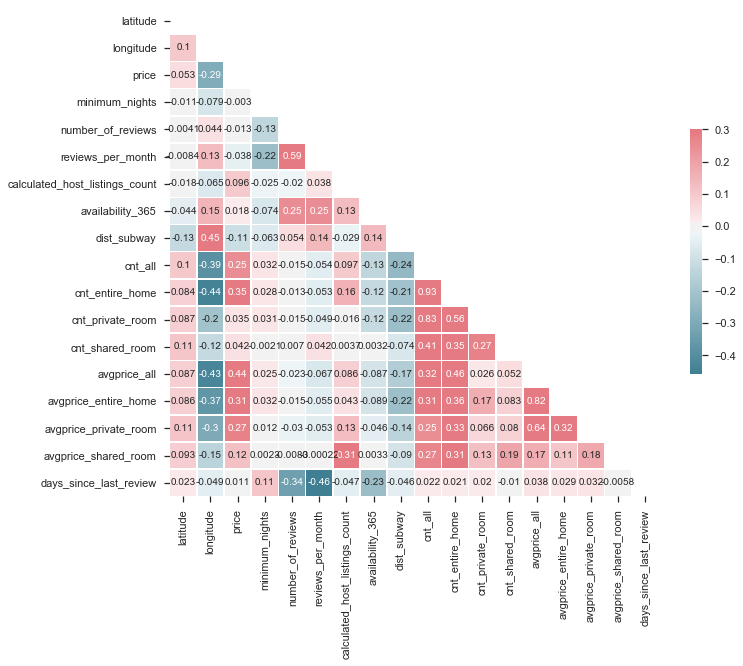

In [373]:
# Compute the correlation matrix
corr = data[list(data.dtypes[data.dtypes == np.float64].index)].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Add Response Column

In [374]:
room_types = {
    'Entire home/apt':0,
    'Private room':1,
    'Shared room': 2
}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)
#data.drop(axis=0, labels=[x for x in data.index if data.iloc[x].Response == 2], inplace=True)

In [375]:
data.dtypes[data.dtypes == np.float64].index

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'dist_subway', 'cnt_all', 'cnt_entire_home',
       'cnt_private_room', 'cnt_shared_room', 'avgprice_all',
       'avgprice_entire_home', 'avgprice_private_room', 'avgprice_shared_room',
       'days_since_last_review'],
      dtype='object')

In [376]:
data.dtypes[data.dtypes == 'category']

neighbourhood_group      category
neighbourhood            category
ZIP                      category
reviews_per_month_cut    category
dtype: object

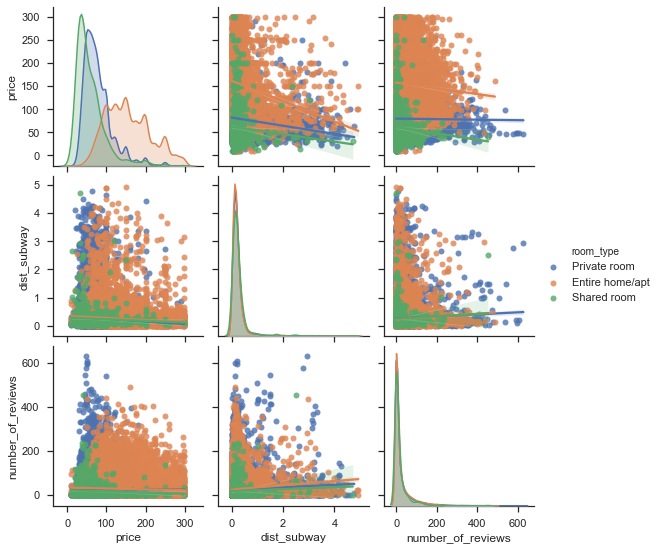

In [377]:
numerics = list(data.dtypes[data.dtypes == np.float64].index)
numerics.append(target)
sns.pairplot(data[['price','dist_subway', 'number_of_reviews', target]], hue=target, kind='reg')

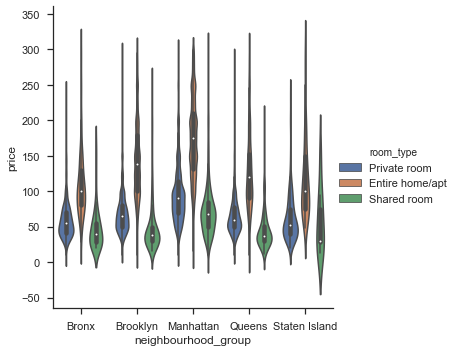

In [378]:
sns.catplot(x='neighbourhood_group', y='price', data=data, hue='room_type', kind='violin')

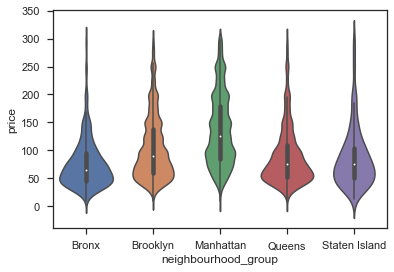

In [379]:
sns.violinplot(x='neighbourhood_group', y='price', data=data)

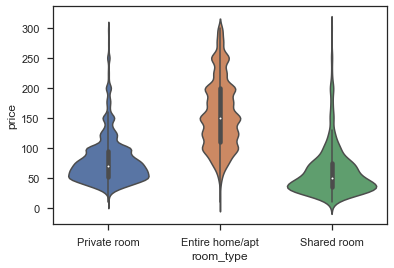

In [380]:
sns.violinplot(x='room_type', y='price', data=data)
#can be used to set cutoffs for outliers

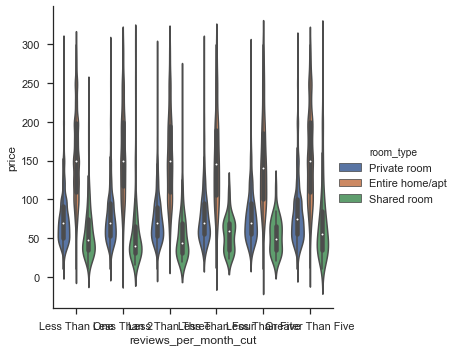

In [381]:
sns.catplot(x='reviews_per_month_cut', y='price', data=data, hue='room_type', kind='violin')

### Data Transforms

    - OHE Encode all categoricals
    - Standard Scale all numerics (sklearn is not R - it does not do this by default)
    - This needs to be done on train/test set separately (create a pipeline) 
    
    https://scikit-learn.org/stable/modules/cross_validation.html
    
    https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [382]:
data_final = data
#OH encode 
label_encode = [x for x, y in dict(data_final.dtypes).items() if type(y) == pd.CategoricalDtype]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    data_final[var].fillna(data_final[var].mode()[0], inplace=True)
    cat_list = f'var_{var}'
    cat_list = pd.get_dummies(data[var], prefix=var)
    data_new = data_final.join(cat_list)
    data_final = data_new

normalize =  [x for x, y in dict(data_final.dtypes).items() if y == np.float64]
for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data_final[col].fillna(data_final[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar = data_final[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar)
        data_final.loc[:,col] = normalizer.transform(ar)

data_final.drop(columns=label_encode, inplace=True)
data_final.drop(columns=target, inplace=True)
#data.fillna(0, inplace=True)
data_final.describe()

neighbourhood_group was OHE'd
neighbourhood was OHE'd
ZIP was OHE'd
reviews_per_month_cut was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_subway,cnt_all,...,ZIP_11692.0,ZIP_11693.0,ZIP_11694.0,ZIP_11697.0,reviews_per_month_cut_Less Than One,reviews_per_month_cut_Less Than 2,reviews_per_month_cut_Less Than Three,reviews_per_month_cut_Less Than Four,reviews_per_month_cut_Less Than Five,reviews_per_month_cut_Greater Than Five
count,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,40180.000000,4.018000e+04,4.018000e+04,4.018000e+04,...,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000
mean,-8.317028e-14,-2.023049e-14,-2.970910e-17,6.224765e-17,1.131775e-17,-7.922428e-17,0.000000,7.922428e-17,-4.244158e-17,-8.488315e-18,...,0.001692,0.001244,0.000224,0.000075,0.466003,0.137780,0.093604,0.060179,0.035565,0.206869
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012,1.000012e+00,1.000012e+00,1.000012e+00,...,0.041104,0.035255,0.014965,0.008641,0.498849,0.344673,0.291280,0.237822,0.185205,0.405066
min,-4.035995e+00,-6.223334e+00,-1.684263e+00,-7.244290e-01,-5.510791e-01,-7.224463e-01,-0.105568,-7.759268e-01,-6.941143e-01,-1.188552e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.009880e-01,-6.667163e-01,-7.991706e-01,-7.244290e-01,-5.298322e-01,-6.864754e-01,-0.105568,-7.759268e-01,-4.069648e-01,-7.670651e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.369378e-01,-8.736238e-02,-2.359299e-01,-3.758605e-01,-4.023512e-01,-4.346791e-01,-0.105568,-5.825001e-01,-2.161266e-01,-2.050820e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.363484e-01,3.582621e-01,5.686997e-01,3.212764e-01,4.383259e-02,3.746661e-01,-0.054144,6.667143e-01,4.509131e-02,4.505649e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.292048e+00,4.968454e+00,2.966496e+00,5.898372e+00,1.281319e+01,3.434918e+01,16.658448,2.165771e+00,1.268775e+01,4.197119e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [383]:
data_final.dtypes['availability_365']

dtype('float64')

### Feature / Target Split

In [385]:
features, target =  data_final.drop(columns=['Response']), data_final.loc[:,['Response']]
features.shape, target.shape

((40180, 448), (40180, 1))

### Train/Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3B1A38C48>,
             colormap=None, colors=None,
             labels=['Entire home/apt', 'Private room', 'Shared room'])

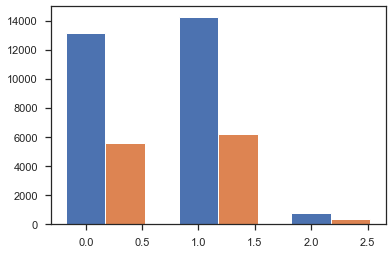

In [386]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
classes_test = ClassBalance(labels=['Entire home/apt', 'Private room', 'Shared room'])
classes_test.fit(y_train['Response'], y_test['Response']) 

### Baseline accuracy rates

In [387]:
baseline_accuracy_train, baseline_accuracy_test = (1-y_train[y_train.Response == 1].shape[0]/y_train.shape[0]) , (1-y_test[y_test.Response == 1].shape[0]/y_test.shape[0])
baseline_accuracy_train, baseline_accuracy_test

(0.49296025030221147, 0.4895470383275261)

### Feature Eng 

    - opted for selection via inspection

In [421]:
from sklearn.feature_selection import RFE
rfe = RFE(lgrg, 10)
rfe = rfe.fit(X_train, y_train.values.ravel())

KeyboardInterrupt: 

In [ ]:
X_train.columns[rfe.support_]

In [389]:
#X_train_fe = X_train[X_train.columns[rfe.support_]]
#X_test_fe = X_test[X_test.columns[rfe.support_]]
data_final.dtypes

latitude                                   float64
longitude                                  float64
price                                      float64
minimum_nights                             float64
number_of_reviews                          float64
                                            ...   
reviews_per_month_cut_Less Than 2            uint8
reviews_per_month_cut_Less Than Three        uint8
reviews_per_month_cut_Less Than Four         uint8
reviews_per_month_cut_Less Than Five         uint8
reviews_per_month_cut_Greater Than Five      uint8
Length: 449, dtype: object

### Fit a Logistic on all predictors

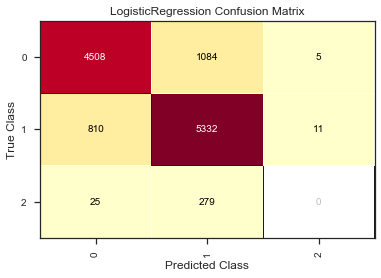

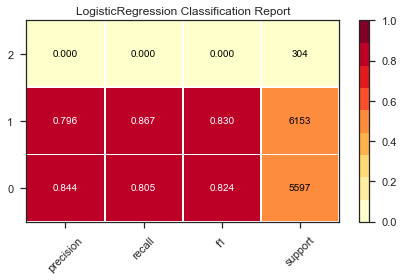

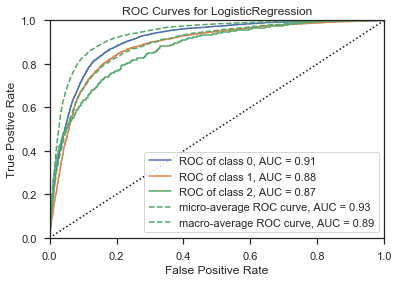

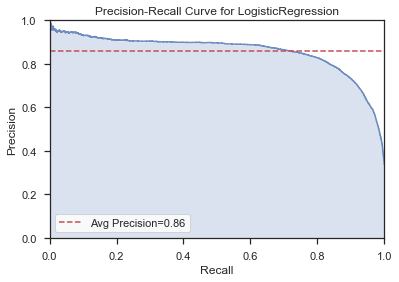

Logit (all features) Accuracy 0.81633
50/50 Accuracy 0.81633 is better than baseline


In [401]:
lgrg_all = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg_all.fit(X_train, y_train.values.ravel())
cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(lgrg_all, X_train, X_test, y_train, y_test)
predict_logit_all = lgrg_all.predict(X_test)
prob_logit_all = lgrg_all.predict_proba(X_test)
acc_logit_all = round(accuracy_score(y_test, predict_logit_all),5)
print(f'Logit (all features) Accuracy {acc_logit_all}')
if cutoffs_lgrg_all:
    best_cutoff_lgrg_all = pd.Series(cutoffs_lgrg_all)[pd.Series(list(scores_lgrg_all['fscore'])).idxmax()]
    adj_acc_logit_all, adj_conf_matrix_logit_all, new_preds_logit_all = compute_new_conf_matrix(predict_logit_all, prob_logit_all, best_cutoff_lgrg_all, y_test)
    print(f'Cutoff ({round(best_cutoff_lgrg_all,4)}) adjusted accuracy: {adj_acc_logit_all}')
    print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.Predict == 1]['ProbTrue'].argmin()])
    print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.NewPredict == 1]['ProbTrue'].argmin()])
    print(f'Cutoff Adjusted Accuracy {adj_acc_logit_all} is {"better than baseline" if adj_acc_logit_all > baseline_accuracy_test else "worse than baseline"}')
    adj_conf_matrix_logit_all

print(f'50/50 Accuracy {acc_logit_all} is {"better than baseline" if acc_logit_all > baseline_accuracy_test else "worse than baseline"}')

### Cols chosen from intuition/EDA

In [402]:
X_train_fe = X_train#[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]
X_test_fe = X_test#[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]

### Basic logistic regression

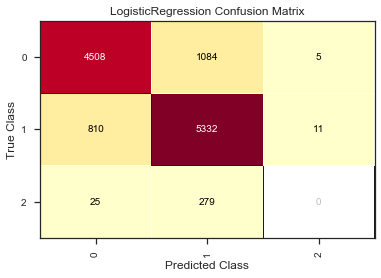

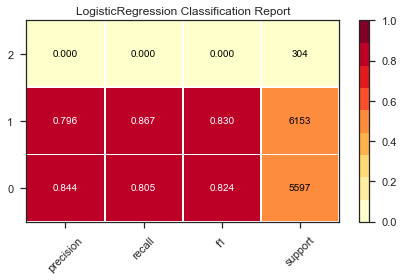

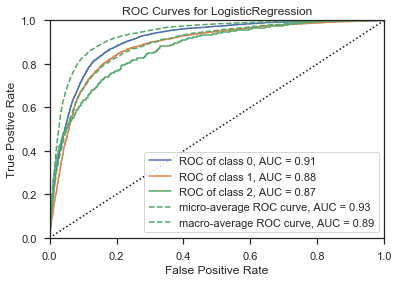

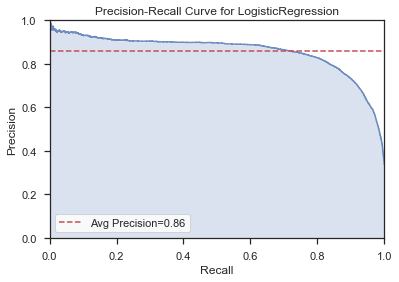

TypeError: 'NoneType' object is not subscriptable

In [403]:
lgrg = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg.fit(X_train_fe, y_train.values.ravel())
cutoffs_lgrg, scores_lgrg = analyze_classifier(lgrg, X_train_fe, X_test_fe, y_train, y_test)
predict_logit = lgrg.predict(X_test_fe)
prob_logit = lgrg.predict_proba(X_test_fe)
best_cutoff_lgrg = pd.Series(cutoffs_lgrg)[pd.Series(list(scores_lgrg['fscore'])).idxmax()]
adj_acc_logit, adj_conf_matrix_logit, new_preds_logit = compute_new_conf_matrix(predict_logit, prob_logit, best_cutoff_lgrg, y_test)
acc_logit = round(accuracy_score(y_test, predict_logit),5)
print(f'Logit Accuracy {acc_logit}')
print(f'Cutoff ({round(best_cutoff_lgrg,4)}) adjusted accuracy: {adj_acc_logit}')
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_logit} is {"better than baseline" if acc_logit > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_logit} is {"better than baseline" if adj_acc_logit > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_logit

### LDA 

 - number of components = 1 (# of reponse variables - 1)

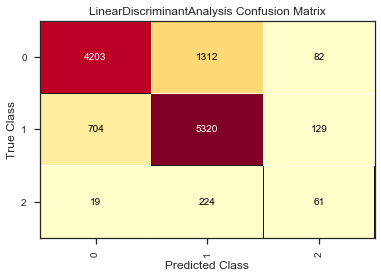

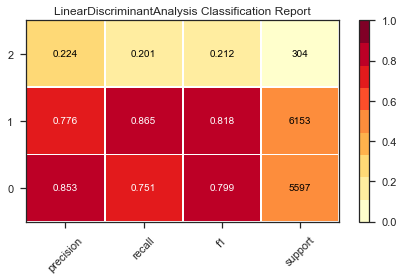

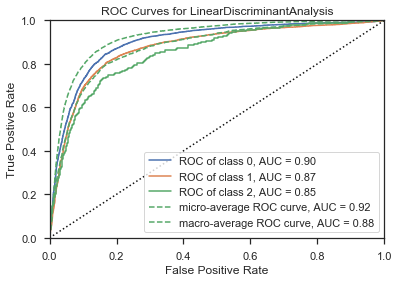

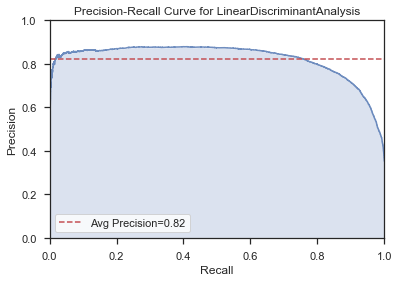

TypeError: 'NoneType' object is not subscriptable

In [404]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_continuous = X_train_fe#[[x for x, y in dict(X_train_fe.dtypes).items() if y == np.float64]]
X_test_continuous = X_test_fe#[[x for x, y in dict(X_test_fe.dtypes).items() if y == np.float64]]
lda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_lda, scores_lda = analyze_classifier(lda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_lda = lda.predict(X_test_fe)
prob_lda = lda.predict_proba(X_test_fe)
best_cutoff_lda = pd.Series(cutoffs_lda)[pd.Series(list(scores_lda['fscore'])).idxmax()]
adj_acc_lda, adj_conf_matrix_lda, new_preds_lda = compute_new_conf_matrix(predict_lda, prob_lda, best_cutoff_lda, y_test)
acc_lda = round(accuracy_score(y_test, predict_lda),5)
print(f'LDA Accuracy {acc_lda}')
print(f'Cutoff ({round(best_cutoff_lda,4)}) adjusted accuracy: {adj_acc_lda}')
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_lda} is {"better than baseline" if acc_lda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_lda} is {"better than baseline" if adj_acc_lda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_lda

### QDA

c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


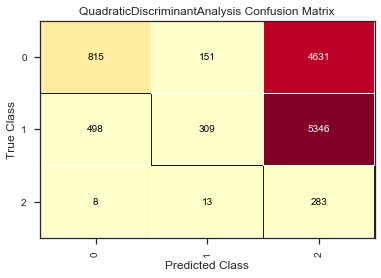

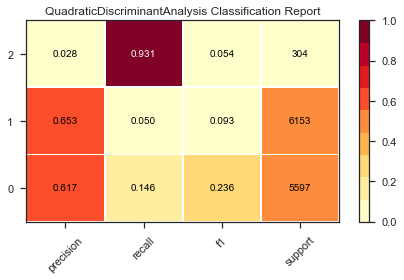

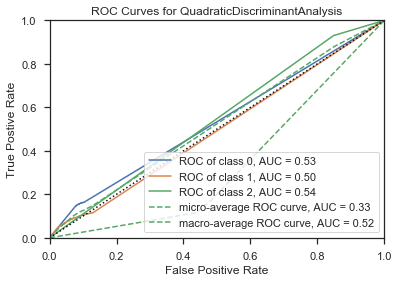

c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


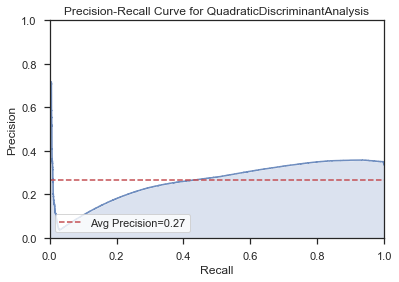

TypeError: 'NoneType' object is not subscriptable

In [405]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()
qda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_qda, scores_qda = analyze_classifier(qda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_qda = qda.predict(X_test_fe)
prob_qda = qda.predict_proba(X_test_fe)
best_cutoff_qda = pd.Series(cutoffs_qda)[pd.Series(list(scores_qda['fscore'])).idxmax()]
adj_acc_qda, adj_conf_matrix_qda, new_preds_qda = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_qda = round(accuracy_score(y_test, predict_qda),5)
print(f'QDA Accuracy {acc_qda}')
print(f'Cutoff ({round(best_cutoff_qda,4)}) adjusted accuracy: {adj_acc_qda}')
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_qda} is {"better than baseline" if acc_qda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_qda} is {"better than baseline" if adj_acc_qda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_qda

In [ ]:
from sklearn.svm import SVC
#support_vec_model = SVC(gamma='auto', kernel='linear', C=0.01)
#support_vec_model.fit(X_train_fe, y_train.values.ravel())
#analyze_classifier(support_vec_model, X_train_fe, X_test_fe, y_train, y_test)

### Naive Bayes

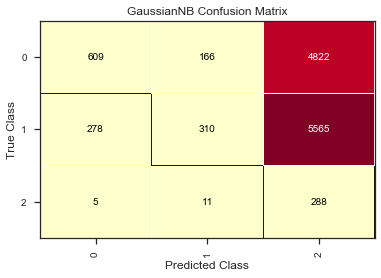

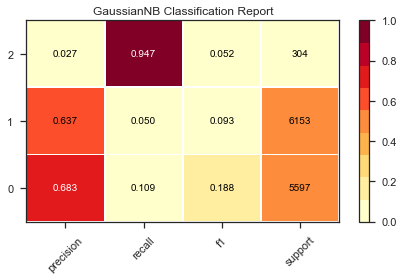

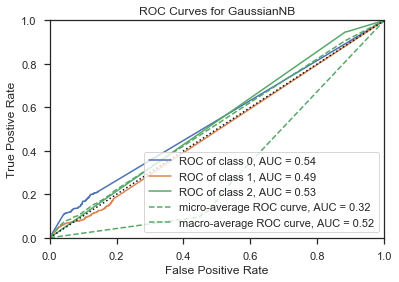

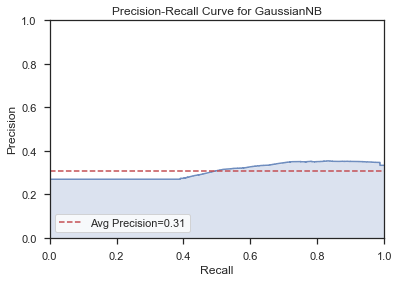

TypeError: 'NoneType' object is not subscriptable

In [406]:
nb = GaussianNB(
   var_smoothing=1e-9
)
cutoffs_nb, scores_nb = analyze_classifier(nb, X_train_fe, X_test_fe, y_train, y_test)
predict_nb = nb.predict(X_test_fe)
prob_nb = nb.predict_proba(X_test_fe)
best_cutoff_nb = pd.Series(cutoffs_nb)[pd.Series(list(scores_nb['fscore'])).idxmax()]
adj_acc_nb, adj_conf_matrix_nb, new_preds_nb = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_nb = round(accuracy_score(y_test, predict_nb),5)
print(f'NB Accuracy {acc_nb}')
print(f'Cutoff ({round(best_cutoff_nb,4)}) adjusted accuracy: {adj_acc_nb}')
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_nb} is {"better than baseline" if acc_nb > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_nb} is {"better than baseline" if adj_acc_nb > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_nb

### Random forest classifier

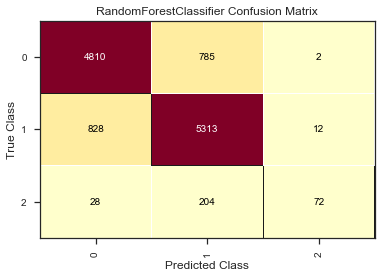

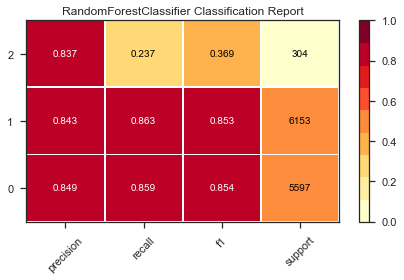

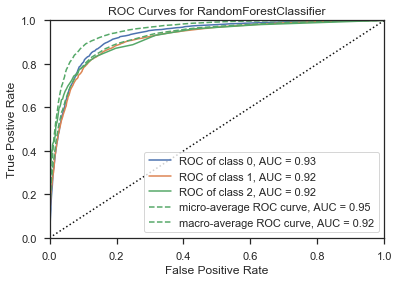

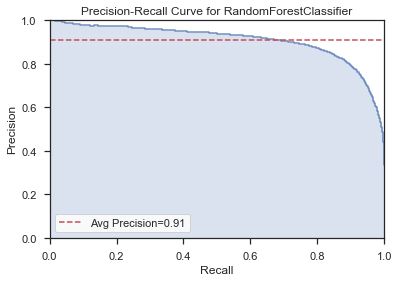

TypeError: 'NoneType' object is not subscriptable

In [407]:
rf_classifier = RandomForestClassifier(
  #max_depth=None,
  random_state=0,
  #bootstrap=True,
  #oob_score=True,
  #max_samples = 50,
  criterion='gini',
  n_estimators=200
)
rf_classifier.fit(X_train_fe, y_train.values.ravel())
cutoffs_rf, scores_rf = analyze_classifier(rf_classifier, X_train_fe, X_test_fe, y_train, y_test)
predict_rf = rf_classifier.predict(X_test_fe)
prob_rf = rf_classifier.predict_proba(X_test_fe)
best_cutoff_rf = pd.Series(cutoffs_rf)[pd.Series(list(scores_rf['fscore'])).idxmax()]
adj_acc_rf, adj_conf_matrix_rf, new_preds_rf = compute_new_conf_matrix(predict_rf, prob_rf, best_cutoff_rf, y_test)
acc_rf = round(accuracy_score(y_test, predict_rf),5)
print(f'RF Accuracy {acc_rf}')
print(f'Cutoff ({round(best_cutoff_rf,4)}) adjusted accuracy: {adj_acc_rf}')
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_rf} is {"better than baseline" if acc_rf > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_rf} is {"better than baseline" if adj_acc_rf > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_rf

### VIF Factors for Final Model

In [418]:
continuous = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month'
              , 'calculated_host_listings_count', 'availability_365', 'dist_subway', 'cnt_all', 'cnt_entire_home', 'cnt_private_room', 'cnt_shared_room'
             , 'avgprice_all', 'avgprice_entire_home', 'avgprice_private_room', 'avgprice_shared_room', 'days_since_last_review']
vif = sklearn_vif(continuous, data_final[continuous])

c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


In [422]:
data_final.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_subway,cnt_all,...,ZIP_11692.0,ZIP_11693.0,ZIP_11694.0,ZIP_11697.0,reviews_per_month_cut_Less Than One,reviews_per_month_cut_Less Than 2,reviews_per_month_cut_Less Than Three,reviews_per_month_cut_Less Than Four,reviews_per_month_cut_Less Than Five,reviews_per_month_cut_Greater Than Five
count,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,4.018000e+04,40180.000000,4.018000e+04,4.018000e+04,4.018000e+04,...,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000,40180.000000
mean,-8.317028e-14,-2.023049e-14,-2.970910e-17,6.224765e-17,1.131775e-17,-7.922428e-17,0.000000,7.922428e-17,-4.244158e-17,-8.488315e-18,...,0.001692,0.001244,0.000224,0.000075,0.466003,0.137780,0.093604,0.060179,0.035565,0.206869
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012,1.000012e+00,1.000012e+00,1.000012e+00,...,0.041104,0.035255,0.014965,0.008641,0.498849,0.344673,0.291280,0.237822,0.185205,0.405066
min,-4.035995e+00,-6.223334e+00,-1.684263e+00,-7.244290e-01,-5.510791e-01,-7.224463e-01,-0.105568,-7.759268e-01,-6.941143e-01,-1.188552e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.009880e-01,-6.667163e-01,-7.991706e-01,-7.244290e-01,-5.298322e-01,-6.864754e-01,-0.105568,-7.759268e-01,-4.069648e-01,-7.670651e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.369378e-01,-8.736238e-02,-2.359299e-01,-3.758605e-01,-4.023512e-01,-4.346791e-01,-0.105568,-5.825001e-01,-2.161266e-01,-2.050820e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.363484e-01,3.582621e-01,5.686997e-01,3.212764e-01,4.383259e-02,3.746661e-01,-0.054144,6.667143e-01,4.509131e-02,4.505649e-01,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.292048e+00,4.968454e+00,2.966496e+00,5.898372e+00,1.281319e+01,3.434918e+01,16.658448,2.165771e+00,1.268775e+01,4.197119e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA on continuous predictors

In [420]:
rf.feature_importance_
#vif

NameError: name 'rf' is not defined

In [ ]:
roc_curve(y_test, predicted_probs.NewPredict)

In [ ]:
roc_auc_score(y_test, predicted_probs.NewPredict)

In [ ]:
vif = sklearn_vif(features.columns, data_final.drop(columns=['Response']))

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pre-process',StandardScaler()), ('pca', pca), ('logistic', lgrg_all)])

#X, y = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 131],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.values.ravel())
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 150)

plt.tight_layout()
plt.show()

In [ ]:
pca.explained_variance_ratio_.sum()